In [1]:
# GPU: RTX 2070 Super

error = 10 ** -5 

def main(device):
    import torch 
    print(torch.__version__)
    print()
    
    dtype = torch.float16

    for N in [20]:
        for C in [16, 64, 256]:
            for H, W in [(28, 28), (64, 64)]:
                for ks in [2, 4]:
                    torch.cuda.empty_cache() # this solves the problem where pytorch GPU tensor is not freed in Jupyter

                    print(f"(N,C,H,W,ks)=({N},{C},{H},{W},{ks})")

                    x0 = torch.randn(N, C, H, W, device=device, dtype=dtype).contiguous(memory_format=torch.channels_last)
                    x1 = x0.clone() 

                    x0.requires_grad_() 
                    x1.requires_grad_()

                    y0 = torch.nn.MaxPool2d(ks, ks, 0, 1)(x0)
                    z0 = y0.sum() 
                    z0.backward(retain_graph=True) 

                    if H % ks == 0 and W % ks == 0:
                        y1 = torch.nn.AdaptiveMaxPool2d((H//ks, W//ks))(x1)
                        assert((y0-y1).abs().max().item() < error)

                        z1 = y1.sum() 
                        z1.backward() 
                        assert((x0.grad.data-x1.grad.data).abs().max().item() < error)

                    def forward():
                        torch.cuda.synchronize()
                        torch.nn.MaxPool2d(2, 2, 0, 1)(x0)
                        torch.cuda.synchronize()

                    print("forward: ")
                    %timeit forward()

                    def backward(): 
                        torch.cuda.synchronize() 
                        z0.backward(retain_graph=True)
                        torch.cuda.synchronize()

                    print("backward: ")
                    %timeit backward()

                    print()

## Before

In [2]:
main("cuda:0")

1.5.0a0+7e55494

(N,C,H,W,ks)=(20,16,28,28,2)
forward: 
81.9 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
401 µs ± 67.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,16,28,28,4)
forward: 
82 µs ± 947 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
364 µs ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,16,64,64,2)
forward: 
89 µs ± 848 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
462 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,16,64,64,4)
forward: 
88 µs ± 283 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
465 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,64,28,28,2)
forward: 
85.9 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
460 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W

## After

In [2]:
main("cuda:0")

1.5.0a0+54c74e1

(N,C,H,W,ks)=(20,16,28,28,2)
forward: 
84.6 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
398 µs ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,16,28,28,4)
forward: 
84.2 µs ± 380 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
428 µs ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,16,64,64,2)
forward: 
90.3 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
469 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,16,64,64,4)
forward: 
89.2 µs ± 406 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
460 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,ks)=(20,64,28,28,2)
forward: 
84.9 µs ± 178 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
backward: 
461 µs ± 6.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,

## Compare

In [3]:
# After manually copying the outputs to before.txt and after.txt 

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

with open('before.txt', 'r') as f: 
    before = f.readlines() 
with open('after.txt', 'r') as f: 
    after = f.readlines() 

def parse(lines):
    d_fwd_time = {}
    d_back_time = {}
    
    for i in range(0, len(lines), 6): 
        line = lines[i] 
        
        tensor_size = line[line.index('=')+1:].rstrip()
        
        key = tensor_size
        
        def parse_time(linex):
            space = linex.index(' ')
            t = float(linex[: space])
            if linex[space + 1] == u'n': 
                t /= 1000 
            elif linex[space + 1] == u'µ':
                pass
            elif linex[space + 1] == u'm': 
                t *= 1000
            
            return t
            
        fwd_time = parse_time(lines[i+2])
        back_time = parse_time(lines[i+4])
    
        d_fwd_time[key] = fwd_time 
        d_back_time[key] = back_time
        
    return (d_fwd_time, d_back_time)   

d_fwd_before, d_back_before = parse(before)
d_fwd_after, d_back_after = parse(after)

def compare(d_before, d_after, s): 
    print('compare for', s)
    print()
    print('tensor size\tbefore\tafter\tregression')
    
    diffs = []
    for key in d_before: 
        t_before = d_before[key] 
        t_after = d_after[key] 
        
        diffs.append((t_after - t_before)/t_before * 100)
        
        if (t_after - t_before) / t_before > 0.05: 
            print(f"{key}", t_before, t_after, 
                  f"{(t_after - t_before) / t_before * 100.0 : .1f}%", sep='\t')
    
    print()
    print('(t_after - t_before) / t_before:')
    print('mean =', np.mean(diffs), '%')
    print('median =', np.median(diffs), '%')
    print('max =', np.max(diffs), '%')
    print('min =', np.min(diffs), '%')
    
    ax = sns.distplot(diffs)
    ax.set(xlabel='percentage regression', ylabel='PDF')
    plt.show()

compare for forward

tensor size	before	after	regression

(t_after - t_before) / t_before:
mean = -1.9422551150398129 %
median = 0.08017947867919739 %
max = 3.2967032967032828 %
min = -14.210526315789473 %


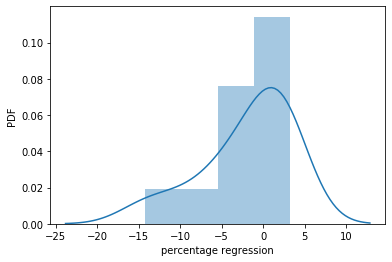

In [4]:
compare(d_fwd_before, d_fwd_after, 'forward')

compare for backward

tensor size	before	after	regression
(20,16,28,28,4)	364.0	428.0	 17.6%

(t_after - t_before) / t_before:
mean = 0.6180732656625209 %
median = -0.22868626415537174 %
max = 17.582417582417584 %
min = -6.593406593406594 %


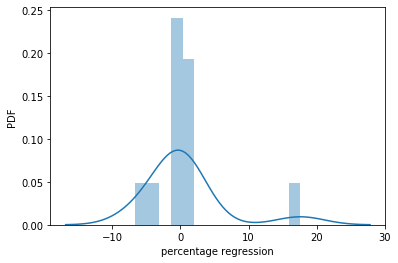

In [5]:
compare(d_back_before, d_back_after, 'backward')